In [27]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [28]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

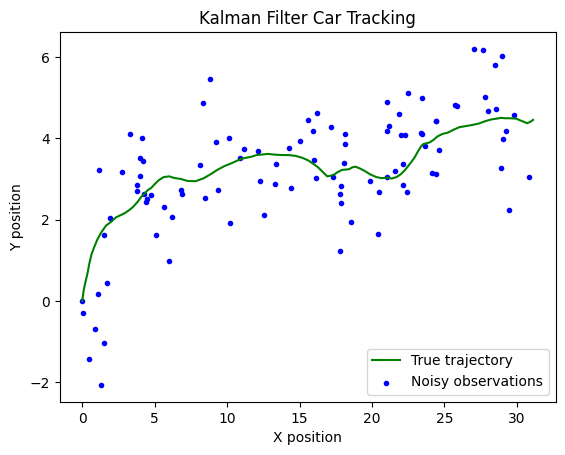

In [29]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [30]:
# EKF with nonlinear true path and nonlinear observations
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_EKF = [m]
Ps = [P]

for y in noisy_observations[1:]:
    F = F_jacobian(m)
    m_pred = f(m)
    P_pred = F @ P @ F.T + Q
    
    H = H_jacobian(m_pred)
    
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - h(m_pred))
    P = P_pred - K @ S @ K.T
        
    Ps.append(P)
    estimated_trajectory_EKF.append(m)

Ps = np.array(Ps)
estimated_trajectory_EKF = np.array(estimated_trajectory_EKF)

In [47]:
# RTS smoother
n, dim_x = estimated_trajectory_EKF.shape

estimated_trajectory_ERTS, P = estimated_trajectory_EKF.copy(), Ps.copy()

for k in range(n-2,-1,-1):
    m_pred = f(estimated_trajectory_ERTS[k])
    P_pred = A @ P[k] @ A.T + Q

    G = P[k] @ A.T @ np.linalg.inv(P_pred)
    estimated_trajectory_RTS[k] += G @ (estimated_trajectory_RTS[k+1] - A @ estimated_trajectory_RTS[k])
    #P[k] += (G @ (P[k+1] - P_pred)) @ G.T

NameError: name 'estimated_trajectory_KF' is not defined

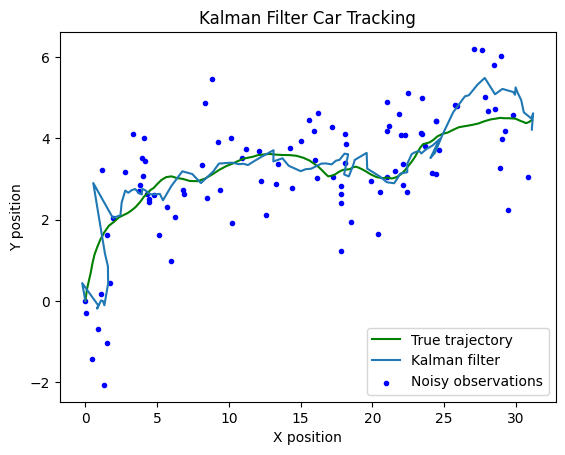

In [40]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.plot(estimated_trajectory_EKF[:, 0], estimated_trajectory_EKF[:, 1], label="Kalman filter")
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

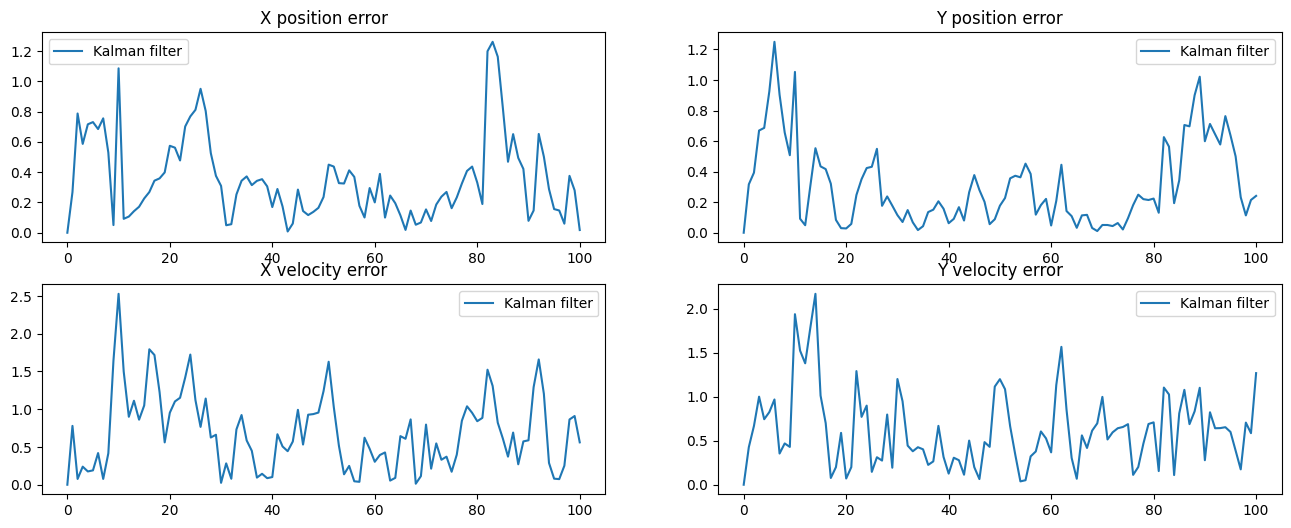

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))
# Flatten ax
ax = ax.flatten()
    
ax[0].plot(np.abs(true_trajectory[:, 0] - estimated_trajectory_EKF[:, 0]), label="Kalman filter")
ax[0].set_title('X position error')
ax[0].legend()

ax[1].plot(np.abs(true_trajectory[:, 1] - estimated_trajectory_EKF[:, 1]), label="Kalman filter")
ax[1].set_title('Y position error')
ax[1].legend()

ax[2].plot(np.abs(true_trajectory[:, 2] - estimated_trajectory_EKF[:, 2]), label="Kalman filter")
ax[2].set_title('X velocity error')
ax[2].legend()

ax[3].plot(np.abs(true_trajectory[:, 3] - estimated_trajectory_EKF[:, 3]), label="Kalman filter")
ax[3].set_title('Y velocity error')
ax[3].legend()
plt.show()